<a href="https://colab.research.google.com/github/hydroeco/hydroeco.github.io/blob/master/00_wellsplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
# import geopandas as gp
import datetime
# import meteolib as meteo
# import evaplib as evap
from datetime import date
import pandas as pd
from scipy import stats as stats
import numpy as np
import urllib3
import glob
# import daymetpy as dm
import time
import sys
import scipy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Navigate to the project folder in your GDrive

In [0]:
## REMPES CHDIR
# os.chdir('/content/drive/My Drive/HP Rivendell')

## DRALLES CHDIR
os.chdir('/content/drive/My Drive/research/HP Rivendell')

In [0]:
welldata = pd.read_csv(
    'https://hydroeco.github.io/angelo/angelo_wells_1H.csv',
     parse_dates=True,
     index_col=0)

welldata = welldata.resample('D').median()

cleaned_old = pd.read_csv('./data/wells_cleaned_old.csv',index_col=0,parse_dates=True)
cleaned_old = cleaned_old.resample('D').median()

currentcols = welldata.columns
oldcols = cleaned_old.columns
remap = []
for col in oldcols:
  checkstr = 'Well_' + col + '_W'
  curr = [item for item in currentcols if checkstr in item][0]
  remap.append(curr)
cleaned_old.columns = remap

dfs = []
for col in cleaned_old.columns:
  tempnew = welldata[col]
  tempold = cleaned_old[col]
  allidx = list(set(tempnew.index).union(tempold.index))
  allidx.sort()
  newdf = pd.DataFrame({col:np.nan},index=allidx)
  idxold = tempold.loc[np.isfinite(tempold)].index.values
  newdf.loc[tempnew.index,col] = tempnew.values
  newdf.loc[idxold,col] = tempold.loc[idxold].values
  dfs.append(newdf)
welldata = pd.concat(dfs,axis=1)
welldata.to_csv('./data/welldata_v3.csv')

In [0]:
def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    df = df[['q']]
    df.q = df.q.astype(float, errors='ignore')
    return df

runoff = getFlow('11475560','2000-01-01','2019-12-30')
runoff = runoff[['q']]*2.447e+12 # convert to mm^3/day
area = 16.8 * 1e+12 # convert to mm/day
runoff = runoff/area
rainfall = pd.read_csv('./data/elder_rainfall.csv', index_col=0,parse_dates=True)

runoff['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in runoff.index]
rainfall['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in rainfall.index]

runoff['wysum'] = runoff.groupby('wy').apply(lambda temp: temp.q.cumsum()).values
rainfall['wysum'] = rainfall.groupby('wy').apply(lambda temp: temp.ppt.cumsum()).values

runoff = runoff['10-2007':'9-2019']
rainfall = rainfall['10-2007':'9-2019']

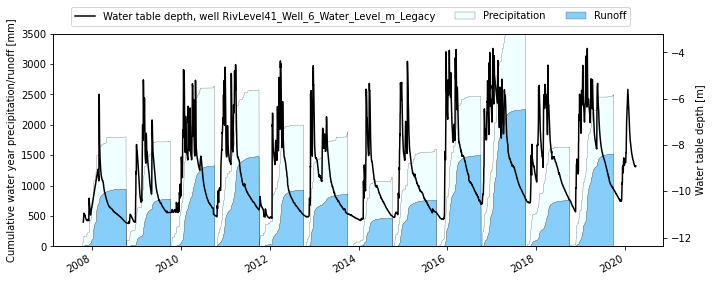

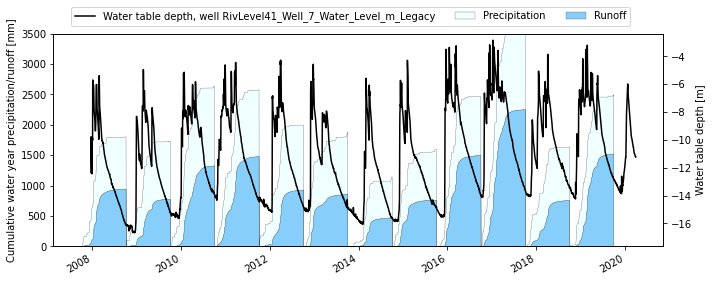

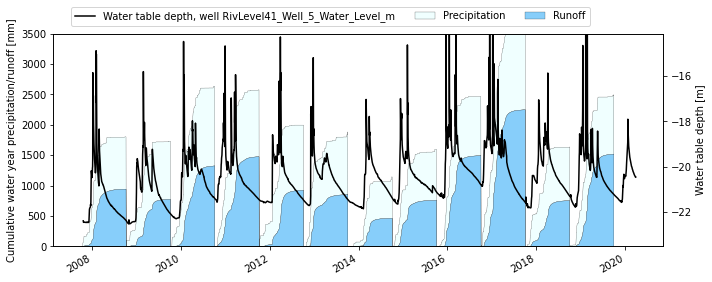

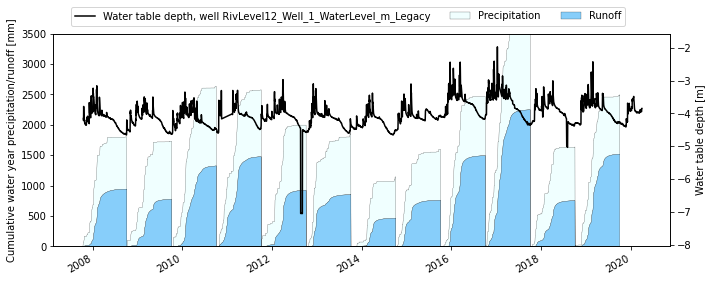

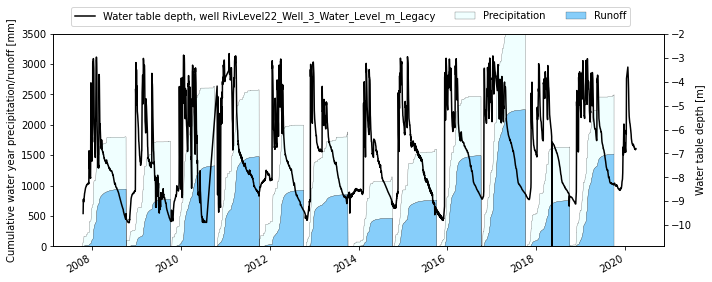

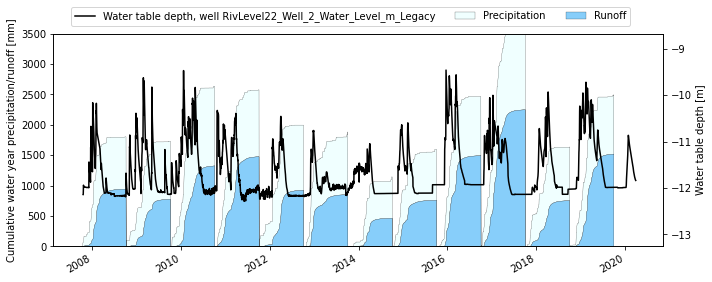

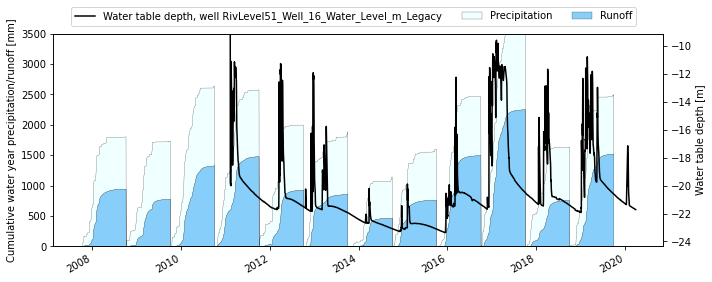

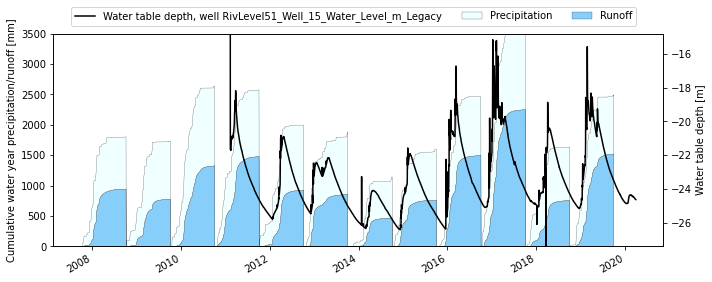

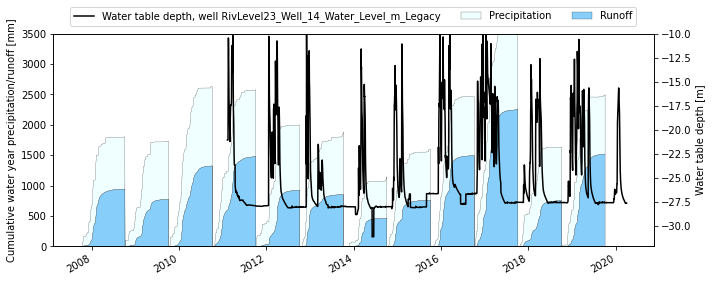

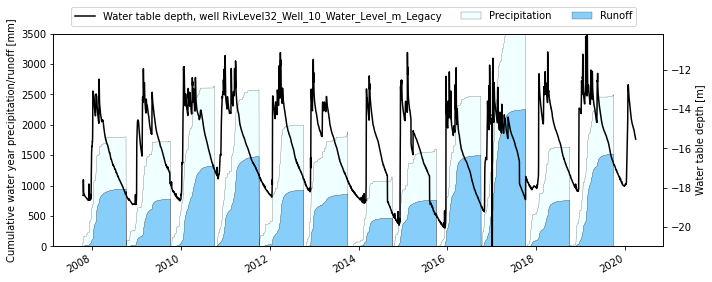

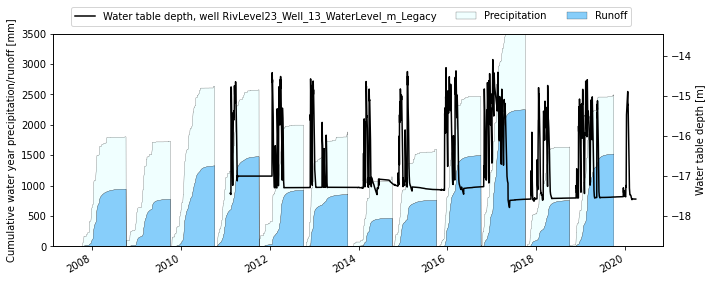

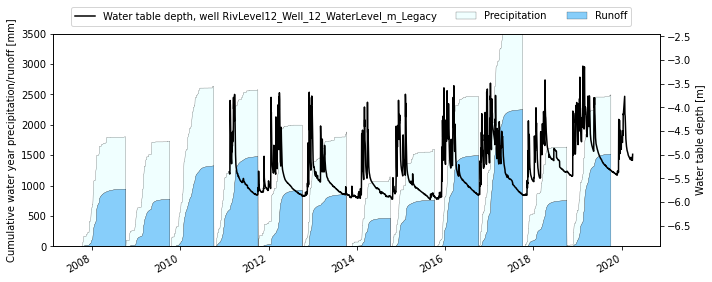

In [59]:
welldata = pd.read_csv('./data/welldata_v3.csv',index_col=0,parse_dates=True)
welldata.interpolate(method='linear',inplace=True)
welldata = welldata.resample('D').median()
welldata.interpolate(method='linear',inplace=True, limit=10)
for col in welldata.columns: 
    f,ax = plt.subplots(1,figsize=(10,4.))
    ax.fill_between(rainfall.index, runoff['wysum'],  rainfall['wysum'], facecolor='azure', label='Precipitation',**{'edgecolor':'k','linewidth':0.2})
    ax.fill_between(rainfall.index, 0,  runoff['wysum'], label='Runoff', facecolor='lightskyblue',**{'edgecolor':'k', 'linewidth':0.2})
    ax.plot(np.nan, 'k', label='Water table depth, well ' + col)
    ax2 = ax.twinx()
    ax2.plot(welldata[col], c='k', label = 'Water table depth')
    ax2.set_ylim([np.min(welldata[col].rolling(window=5).mean())-1, 1+np.max(welldata[col].rolling(window=5).mean())])
    ax2.plot(np.nan, c='k', label = 'Cumulative precipitation')
    ax2.set_ylabel('Water table depth [m]')
    ax.set_ylabel('Cumulative water year precipitation/runoff [mm]')
    ax.set_ylim([0,3500])
    ax.legend(bbox_to_anchor=[0.02, 1.08], loc='center left',ncol=4)
    f.autofmt_xdate()
    f.tight_layout()
